# **Metal Surface Defects Inspection**

Metal surface defect detection is an essential and necessary process to control the qualities of industrial products. However, due to the limited data scale and defect categories, existing defect datasets are generally unavailable for the deployment of the detection model. To address this problem, we using a **NEU surface defect database** with six kinds of typical surface defects.

 This dataset was downloaded from NEU Metal Surface Defects Databse which contains six kinds of typical surface defects of the hot-rolled steel strip are collected, i.e., rolled-in scale (RS), patches (Pa), crazing (Cr), pitted surface (PS), inclusion (In) and scratches (Sc). The database includes 1,800 grayscale images: 300 samples each of six different kinds of typical surface defects.

 the dataset divided into 3 directories. The training directory contains 276 images of each class from the 300 images. The rest 24 images of each class also divided into tests and valid datasets.

# Liberaries

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import cv2
import time
import json
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from train import train_model
from data_utils import create_validation_data
from vis_utils import imshow

In [ ]:
from data_utils import create_validation_data

# helper

In [9]:
def get_model(model_name, pretrained=False):
    return models.__dict__[model_name](pretrained)

def imshow(img, mean, std, text=None, should_save=False):
    # convert from torch tensor to numpy array
    img_np = img.numpy().transpose((1, 2, 0))  # (C, H, W) -> (H, W, C)

    # denormalize
    img_np = img_np * std + mean
    img_np = img_np.clip(0., 1.)

    # plot
    plt.axis("off")
    if text:
        plt.text(160, 8, text, style='italic', fontweight='bold',
                 bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    plt.imshow(img_np)
    plt.show()


def show_image_pair(img1, img2, text=None):
    concat = torch.cat((img1.unsqueeze(0), img2.unsqueeze(0)), 0)
    imshow(torchvision.utils.make_grid(concat), text)

In [10]:
import numpy as np
import pandas as pd
import os

# Data set

In [11]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
import zipfile

In [13]:

# Define the path to your dataset zip file in Google Drive
google_drive_path = '/content/drive/My Drive/computervision/NEU Dataset.zip'

In [14]:
# Specify the directory where you want to extract the dataset
extract_dir = '/content/dataset/'

In [15]:
import zipfile

# Define the path to your dataset zip file in Google Drive
google_drive_path = '/content/drive/My Drive/computervision/NEU Dataset.zip'

# Specify the directory where you want to extract the dataset
extract_dir = '/content/dataset/'

# Verify the existence of the zip file
if os.path.exists(google_drive_path):
    # Extract the zip file
    with zipfile.ZipFile(google_drive_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)
else:
    print(f"File not found: {google_drive_path}")


In [16]:
directory = os.getcwd()


In [17]:
import os

# Define the directory path
directory = '/content/drive/My Drive/computervision'  # Replace with your directory path

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(directory):
    os.makedirs(directory)
    print(f"Directory '{directory}' has been created.")
else:
    print(f"Directory '{directory}' already exists.")



Directory '/content/drive/My Drive/computervision' already exists.


In [18]:
folder_contents = os.listdir(directory)


In [19]:
for item in folder_contents:
    print(item)


NEU Dataset.zip
NEU Metal Surface Defects Dataset


In [20]:
# Extract the zip file
with zipfile.ZipFile(google_drive_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

In [21]:
import os

In [22]:
# Check the contents of the extracted dataset folder
os.listdir(extract_dir)

['NEU Metal Surface Defects Dataset']

In [23]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
!pip install pillow

In [46]:

# Commented out IPython magic to ensure Python compatibility.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms


# Update DATA_DIR to the path in your Google Colab environment
DATA_DIR = '/content/drive/My Drive/computervision/NEU Metal Surface Defects Dataset/'





In [47]:
# Check directory contents
os.listdir(DATA_DIR)

['valid', 'train', 'test']

In [48]:
trn_dir = f'{DATA_DIR}train'
val_dir = f'{DATA_DIR}valid'

In [49]:
os.listdir(trn_dir)

['Scratches', 'Pitted', 'Rolled', 'Patches', 'Inclusion', 'Crazing']

In [50]:
trn_fnames = glob.glob(f'{trn_dir}/*/*.bmp')
trn_fnames[:5]

['/content/drive/My Drive/computervision/NEU Metal Surface Defects Dataset/train/Scratches/Sc_123.bmp',
 '/content/drive/My Drive/computervision/NEU Metal Surface Defects Dataset/train/Scratches/Sc_122.bmp',
 '/content/drive/My Drive/computervision/NEU Metal Surface Defects Dataset/train/Scratches/Sc_124.bmp',
 '/content/drive/My Drive/computervision/NEU Metal Surface Defects Dataset/train/Scratches/Sc_121.bmp',
 '/content/drive/My Drive/computervision/NEU Metal Surface Defects Dataset/train/Scratches/Sc_120.bmp']

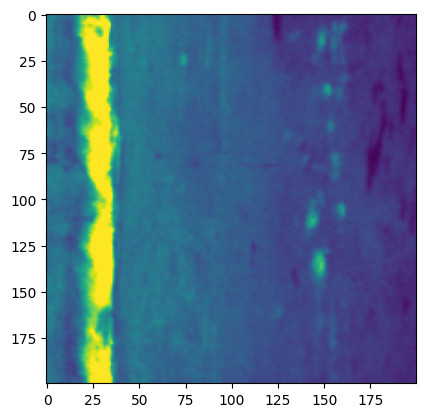

In [51]:
img = plt.imread(trn_fnames[3])
plt.imshow(img)
plt.show()  # Use plt.show() if image display doesn't work as expected

In [52]:
# some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

In [53]:
use_gpu

False

In [54]:
train_ds = datasets.ImageFolder(trn_dir)

In [55]:
train_ds.classes

['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']

In [56]:
train_ds.class_to_idx

{'Crazing': 0,
 'Inclusion': 1,
 'Patches': 2,
 'Pitted': 3,
 'Rolled': 4,
 'Scratches': 5}

In [57]:
train_ds.root

'/content/drive/My Drive/computervision/NEU Metal Surface Defects Dataset/train'

In [58]:
train_ds.imgs[:5]

[('/content/drive/My Drive/computervision/NEU Metal Surface Defects Dataset/train/Crazing/Cr_120.bmp',
  0),
 ('/content/drive/My Drive/computervision/NEU Metal Surface Defects Dataset/train/Crazing/Cr_121.bmp',
  0),
 ('/content/drive/My Drive/computervision/NEU Metal Surface Defects Dataset/train/Crazing/Cr_122.bmp',
  0),
 ('/content/drive/My Drive/computervision/NEU Metal Surface Defects Dataset/train/Crazing/Cr_123.bmp',
  0),
 ('/content/drive/My Drive/computervision/NEU Metal Surface Defects Dataset/train/Crazing/Cr_124.bmp',
  0)]

In [59]:
type(train_ds.transform)

NoneType

In [60]:
target_size=(200, 200)
batch_size=10

# Data transformations/agmuntation for training and validation

In [61]:
"""#Transformations : Dataloader object uses these tranformations when loading data."""

tfms = transforms.Compose([
    transforms.Resize((200, 200)),  # PIL Image
    transforms.ToTensor(),        # Tensor
    transforms.Normalize([0.5], [0.5])  # Grayscale normalization
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [62]:
#Create Training/Validation/Test dataset
train_ds = datasets.ImageFolder(trn_dir, transform=tfms)
valid_ds = datasets.ImageFolder(val_dir, transform=tfms)

In [63]:
len(train_ds), len(valid_ds)

(1656, 72)

In [64]:
train_dl = torch.utils.data.DataLoader(train_ds,
                                       batch_size=batch_size,
                                       shuffle=True,
                                       num_workers=2)

valid_dl = torch.utils.data.DataLoader(valid_ds,
                                       batch_size=batch_size,
                                       shuffle=False,
                                       num_workers=2)
# for strong system num of workers can increase till 8 or more

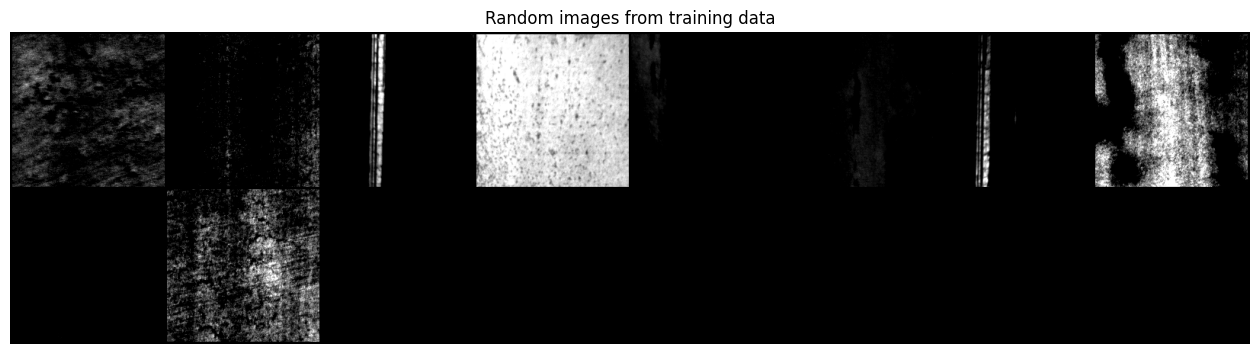

In [66]:
# Assuming you have a DataLoader named train_dl
inputs, targets = next(iter(train_dl))

# Create a grid of images (you can adjust padding as needed)
out = torchvision.utils.make_grid(inputs, padding=3)

# Convert the tensor to a NumPy array and transpose it to (height, width, channels)
out = out.permute(1, 2, 0).numpy()

# Ensure the pixel values are in the valid range for displaying RGB images
out = out.clip(0.0, 1.0)  # Clip values to [0.0, 1.0]

# Display the random images
plt.figure(figsize=(16, 12))
plt.imshow(out)
plt.title('Random images from training data')
plt.axis('off')  # Remove axis labels
plt.show()


In [25]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import os

# Update DATA_DIR to the path in your Google Colab environment
DATA_DIR = '/content/drive/My Drive/computervision/NEU Metal Surface Defects Dataset/'




In [26]:
# Check directory contents
os.listdir(DATA_DIR)

['test', 'valid', 'train']

In [27]:
trn_dir = f'{DATA_DIR}train'
val_dir = f'{DATA_DIR}valid'

In [28]:
os.listdir(trn_dir)

['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']

In [29]:
# preprocessing
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


test_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 10 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        trn_dir,
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical')

# Flow validation images in batches of 10 using test_datagen generator
validation_generator = test_datagen.flow_from_directory(
        val_dir,
        target_size=(200, 200),
        batch_size=10,
        class_mode='categorical')

Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


#Stop training the model at 98% traning accuracy





In [30]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.98 ):
            print("\nReached 98% accuracy so cancelling training!")
            self.model.stop_training = True

In [31]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (2,2), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 199, 199, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 98, 98, 64)        8256      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 49, 49, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 128)       32896     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 24, 24, 128)       0

In [32]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
print('Compiled!')

Compiled!


In [33]:
callbacks = myCallback()
history = model.fit(train_generator,
        batch_size = 32,
        epochs=20,
        validation_data=validation_generator,
        callbacks=[callbacks],
        verbose=1, shuffle=True)

Epoch 1/20
166/166 [==============================] - 409s 2s/step - loss: 1.6610 - accuracy: 0.3502 - val_loss: 0.8941 - val_accuracy: 0.7361
Epoch 2/20
166/166 [==============================] - 21s 125ms/step - loss: 1.0586 - accuracy: 0.6063 - val_loss: 0.4711 - val_accuracy: 0.8472
Epoch 3/20
166/166 [==============================] - 21s 123ms/step - loss: 0.7926 - accuracy: 0.7192 - val_loss: 0.8274 - val_accuracy: 0.7083
Epoch 4/20
166/166 [==============================] - 23s 138ms/step - loss: 0.5987 - accuracy: 0.7874 - val_loss: 0.2168 - val_accuracy: 0.9444
Epoch 5/20
166/166 [==============================] - 23s 136ms/step - loss: 0.5130 - accuracy: 0.8182 - val_loss: 0.1197 - val_accuracy: 0.9722
Epoch 6/20
166/166 [==============================] - 21s 126ms/step - loss: 0.4610 - accuracy: 0.8424 - val_loss: 0.3473 - val_accuracy: 0.9167
Epoch 7/20
166/166 [==============================] - 22s 134ms/step - loss: 0.3863 - accuracy: 0.8665 - val_loss: 0.3424 - val_accu

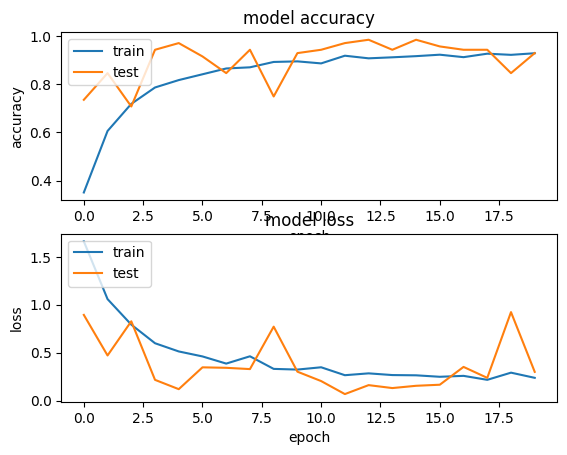

In [34]:
import matplotlib.pyplot as plt
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss

plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Test Result visualization

In [50]:
# Update DATA_DIR to the path in your Google Colab environment
DATA_DIR = '/content/drive/My Drive/computervision/NEU Metal Surface Defects Dataset/'



In [51]:
# Check directory contents
os.listdir(DATA_DIR)

['test', 'valid', 'train']

In [35]:
test_dir = f'{DATA_DIR}test'

In [37]:
os.listdir(test_dir)

['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']

In [38]:
# First, we are going to load the file names and their respective target labels into numpy array!
from sklearn.datasets import load_files
import numpy as np

test_dir = f'{DATA_DIR}test'

def load_dataset(path):
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np.array(data['target'])
    target_labels = np.array(data['target_names'])
    return files,targets,target_labels

x_test, y_test,target_labels = load_dataset(test_dir)

In [39]:
no_of_classes = len(np.unique(y_test))
no_of_classes

6

In [41]:
from keras.utils import to_categorical

# Assuming y_test is your labels (class indices)
# Replace no_of_classes with the number of classes in your problem
y_test_encoded = to_categorical(y_test, num_classes=no_of_classes)


In [42]:
# We just have the file names in the x set. Let's load the images and convert them into array.
from keras.preprocessing.image import array_to_img, img_to_array, load_img

def convert_image_to_array(files):
    images_as_array=[]
    for file in files:
        # Convert to Numpy Array
        images_as_array.append(img_to_array(load_img(file)))
    return images_as_array

x_test = np.array(convert_image_to_array(x_test))
print('Test set shape : ',x_test.shape)

Test set shape :  (72, 200, 200, 3)


In [43]:
x_test = x_test.astype('float32')/255

3/3 [==============================] - 0s 11ms/step


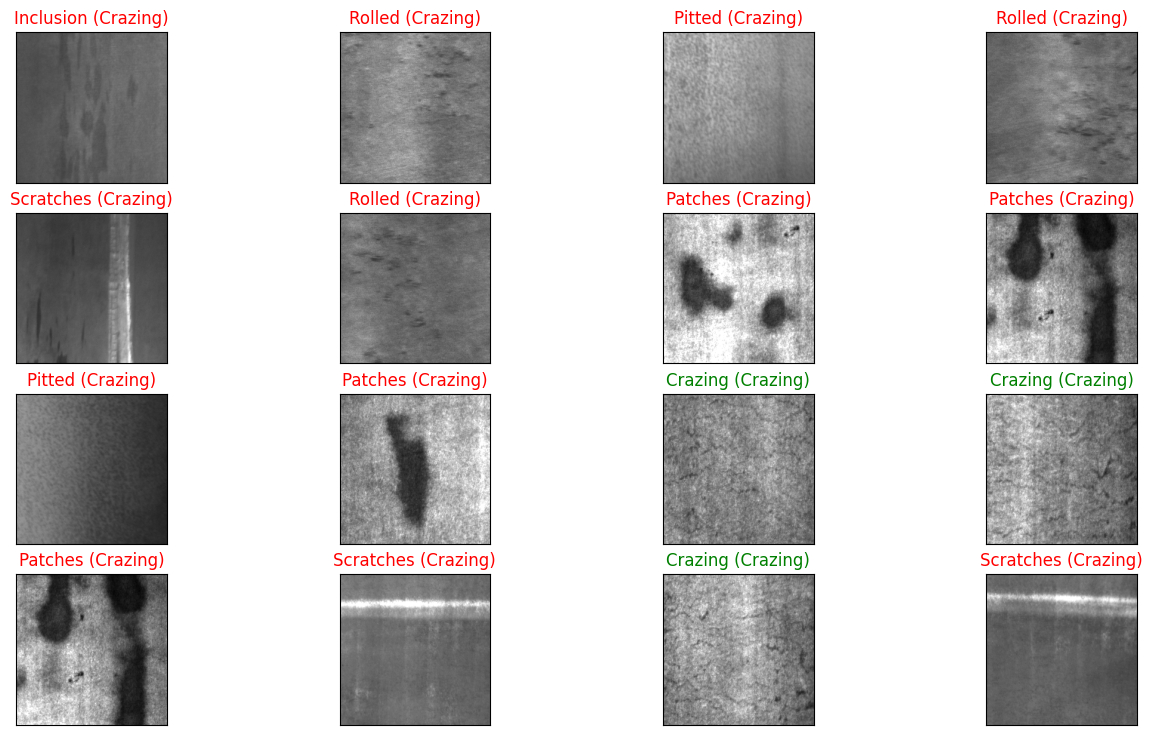

In [49]:
# Let's visualize test prediction.

y_pred = model.predict(x_test)

# plot a raandom sample of test images, their predicted labels, and ground truth
fig = plt.figure(figsize=(16, 9))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = np.argmax(y_pred[idx])
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(target_labels[pred_idx], target_labels[true_idx]),
                 color=("green" if pred_idx == true_idx else "red"))

    # when model's prediction is incorrect, and the title text will be displayed in red.
    # when model's prediction is correct, and the title text will be displayed in green.